In [10]:

import torch
import vegas
from nisrep.normalizing_flows.manager import *
import matplotlib.pyplot as plt
import numpy as np
torch.set_default_dtype(torch.double)

In [2]:
"""
def g(x):
    return torch.exp(-torch.sum(x**2,axis=-1)) #Vanilla Gaussian

def g(x): #ring, expect 0.51 in 2 dim
    q=torch.sqrt(torch.sum(x**2,axis=-1))
    #print(q)
    f=q.clone()
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
    z=torch.where(q>0.45,a,q)
    #print(z)
    #print(torch.where(z>1,a,b))
    return torch.where(z<0.2,a,b)
"""

def g(x): #box: expect 16 in dim 2, 64 in dim 3
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q>2,a,b)
"""
def tanp(x):
    return 100*(1+((torch.tan((x-0.5)*np.pi))**2))*np.pi   #derivative for jacobian

def gaussianp(x):
    mu=0
    sigma=1
    return torch.prod(-((x-mu)*torch.unsqueeze(torch.exp(-torch.sum((x-mu)**2/2*sigma**2,-1))/(np.sqrt(2*np.pi)*sigma**3),dim=-1)),-1)
"""
def normal(x,mu, sigma, n_flow):
    return (torch.exp(-torch.sum((x-mu)**2/(2*sigma**2),-1)))/(sigma*np.sqrt((2*np.pi)**n_flow))

n_flow=2
w = torch.empty((50000,n_flow)) 
torch.nn.init.uniform_(w)
v=100*torch.tan((w-0.5)*(np.pi))
print(v)
print("Value of the integral before mapping by CL")
print(torch.mean(torch.mul(g(v),torch.abs(torch.prod(tanp(w),axis=-1)))))
#print(torch.var(torch.mul(g(v),torch.prod(tanp(w),axis=-1))))

NF =  AffineManager(n_flow=n_flow)
NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[20,20,20], roll_step=1)
#print(v)
v=NF.model(NF.format_input(v, dev=v.device))
jac=v[:,-1]
print(jac)
v=v[:,:n_flow]

mult=torch.mul(g(v),jac)

print("Value of the integral after mapping by CL")
print(torch.mean(torch.mul(mult,torch.prod(tanp(w),axis=-1))))


w = torch.empty((5000000,n_flow)) 
Z=torch.nn.init.normal_(w,std=1)

print("Value of the integral in gaussian")

print(torch.mean(g(Z)/(normal(Z,0,1,n_flow)))) 



tensor([[-11.9237, 399.1346],
        [ 39.8049, -57.4831],
        [124.0745, 126.5498],
        ...,
        [  8.2447, -35.4974],
        [-16.3522, -49.2863],
        [204.1848, 224.0816]])
Value of the integral before mapping by CL


NameError: name 'tanp' is not defined

In [6]:
def g(x): #box: expect 0.25 in dim2, 0,0039 in dim 8, 0,00195 in dim 9
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q>0.5,a,b)

def gs(x): #box: expect 0.25 in dim2, 0,0039 in dim 8, 0,00195 in dim 9
   
    q=torch.max(torch.abs(x),dim=-1).values
    #s=torch.min(torch.abs(x),dim=-1).values
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
    ret= torch.where(q>0.5,a,b)
    sret=torch.where((q>0.6)&(q<0.65),ret,5*b)
    return sret

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.05**2)) 

def gp(x):
    #s=100*gaussian(x)
    s=(1/((x[:,0]-0.5)**2+0.001**2))
    q=(1/((x[:,1])**2+0.001**2))
    t=100*torch.ones_like(x[:,0])
    return s+t+q
gp=g    
n_flow=2
w = torch.empty((100000,n_flow)) 
torch.nn.init.uniform_(w)

print("Value of the integral before mapping by CL")
print(torch.mean(gp(w)))
#print("Value of the integral before mapping by CL minus constant")
#print(torch.mean(gp(w)-100))
#print("Variance")
#print(torch.var(gp(w)))
#print("SDEV")
#print(torch.std(gp(w)))
#print("Assumed error")
#print(torch.std(gp(w))/np.sqrt(250000))

#NF =  PWQuadManager(n_flow=n_flow)
#NF.create_model(n_cells=2, n_bins=10, NN=[10,10,10], dev=torch.device("cpu"))
#print(v)
NF =  AffineManager(n_flow=n_flow)
#NF.create_model(n_cells=2, n_bins=10, NN=[11,11,11],dev=torch.device("cpu"))
NF.create_model(n_cells=2, NN=[11,11,11], n_pass_through=1, roll_step=1)
v=NF.model(NF.format_input(w,torch.device("cpu")))
jac=v[:,-1]
print(jac)
v=v[:,:n_flow]
print(v)
print(torch.min(v))
print(torch.max(v))
print(gp(v))
mult=torch.mul(gp(v),jac)
print("Value of the integral after mapping by CL")
print(torch.mean(mult))
"""
optim = torch.optim.Adamax(NF._model.parameters(),lr=1e-3, weight_decay=1e-5) 
res,err=NF._train_variance_forward_seq(gp,optim, False,"./logs/tmp/",1000,200,
                                           pretty_progressbar=True,save_best=True,run=None,dev=0,
                                               integrate=True,preburn_time=50)

print("Result")
print(res)
print(err)
#print(err/np.sqrt(500))
v=NF.best_model(NF.format_input(w,torch.device("cpu")))
jac=v[:,-1]
#print(jac)
v=v[:,:n_flow]
mult=torch.mul(gp(v),jac)
print("Loss reduction")
print(NF.best_loss/NF.int_loss)
print("Variance reduction")
print(torch.var(mult)/torch.var(gp(w)))
print("Value of the integral after mapping by training")
print(torch.mean(mult))
print("Value of the integral after mapping by training new device")
print(NF.integrate(gp,25,10000))
"""

Value of the integral before mapping by CL
tensor(0.2511)
tensor([0.1103, 0.1648, 0.1423,  ..., 0.0902, 0.6977, 0.5680],
       grad_fn=<SelectBackward>)
tensor([[0.8655, 0.7213],
        [0.5799, 0.9192],
        [0.8116, 0.7817],
        ...,
        [0.7747, 0.8548],
        [0.8399, 0.4753],
        [0.7514, 0.7917]], grad_fn=<SliceBackward>)
tensor(2.8094e-05, grad_fn=<MinBackward1>)
tensor(0.9666, grad_fn=<MaxBackward1>)
tensor([0., 0., 0.,  ..., 0., 0., 0.])
Value of the integral after mapping by CL
tensor(0.2622, grad_fn=<MeanBackward0>)


'\noptim = torch.optim.Adamax(NF._model.parameters(),lr=1e-3, weight_decay=1e-5) \nres,err=NF._train_variance_forward_seq(gp,optim, False,"./logs/tmp/",1000,200,\n                                           pretty_progressbar=True,save_best=True,run=None,dev=0,\n                                               integrate=True,preburn_time=50)\n\nprint("Result")\nprint(res)\nprint(err)\n#print(err/np.sqrt(500))\nv=NF.best_model(NF.format_input(w,torch.device("cpu")))\njac=v[:,-1]\n#print(jac)\nv=v[:,:n_flow]\nmult=torch.mul(gp(v),jac)\nprint("Loss reduction")\nprint(NF.best_loss/NF.int_loss)\nprint("Variance reduction")\nprint(torch.var(mult)/torch.var(gp(w)))\nprint("Value of the integral after mapping by training")\nprint(torch.mean(mult))\nprint("Value of the integral after mapping by training new device")\nprint(NF.integrate(gp,25,10000))\n'

In [4]:
n_flow=2
w = torch.empty((1000,n_flow)) 
torch.nn.init.uniform_(w)
maxim=torch.max(normal(w,0,1,n_flow))
i=0
res=0
q=0
while(i<5000):
    q=q+1
    w = torch.empty((1,n_flow)) 
    torch.nn.init.uniform_(w)
    w2=torch.empty((1,1))
    inter=normal(w,0,1,n_flow)
    if(inter/maxim>w2):
        res+=inter
        i=i+1
    if(i%1000==0):
        print(i)
print((res/5000)*5000/q)

print("Value of the integral before mapping by CL")
print(torch.mean(normal(w,0,1,n_flow)))

1000
2000
3000
3000
3000
3000
4000
5000
tensor([0.0846])
Value of the integral before mapping by CL
tensor(0.1500)


In [5]:
w = torch.empty((120000,1)) 
torch.nn.init.uniform_(w)
z=torch.mean(1+torch.cos((w-0.5)*np.pi)**2)*np.pi#*16*(1.6)**4
print(1+torch.cos((w-0.5)*np.pi)**2)
print(z)

tensor([[1.9990],
        [1.7260],
        [1.0655],
        ...,
        [1.8051],
        [1.9822],
        [1.4402]])
tensor(4.7089)


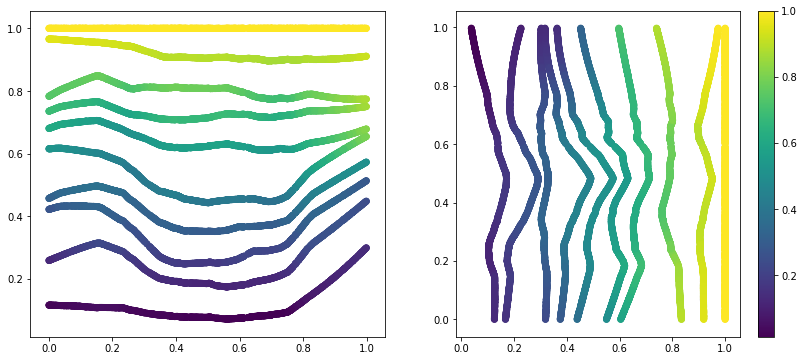

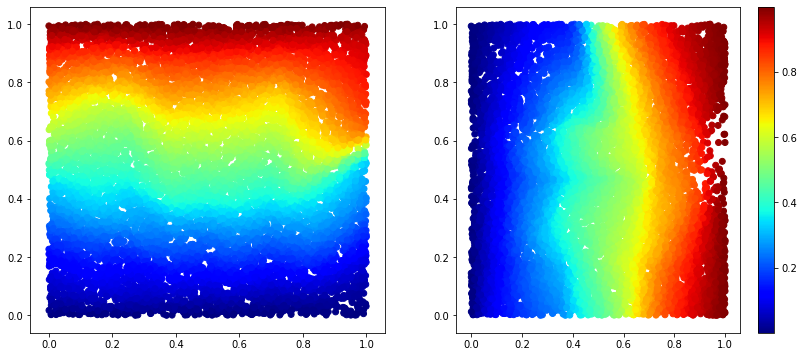

In [8]:
NF=PWQuadManager(2)
NF.create_model(n_cells=2, n_bins=10, NN=[16,16,16])
fig = plt.figure(figsize=(14, 6))
a5=fig.add_subplot(121)


w = torch.empty((1000,n_flow)) 
torch.nn.init.uniform_(w,0,1)

for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            Z=m[1].NN(w[:,:1])
            
            W=Z[:,:,m[1].n_bins+1:]
           
            W=torch.exp(W)
        
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
           
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            
            coords=np.stack([w[:,0].numpy() for 
                             _ in range(m[1].n_bins)], axis=0).reshape(w.shape[0]*m[1].n_bins,-1)
            
                
            
            
            plt.scatter(coords,torch.squeeze(Wsum,-1).detach().numpy(),c=torch.squeeze(VW,-1).detach().numpy())
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
      
        
        if(m[0]=='1'):
            a6=fig.add_subplot(122)
            
        
            Z=m[1].NN(torch.unsqueeze(w2[:,1],-1))
            
            W=Z[:,:,m[1].n_bins+1:]
            W=torch.exp(W)
            w2=w2.detach()
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w2.shape[0],1,-1)
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            coords=np.stack([w2[:,1].numpy() for _ in range(m[1].n_bins)], axis=0)  
            
            plt.scatter(torch.squeeze(Wsum,-1).detach().numpy(), coords, c=torch.squeeze(VW,-1).detach().numpy())

plt.colorbar()


fig = plt.figure(figsize=(14, 6))
a7=fig.add_subplot(121)

w = torch.empty((10000,2)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            
           
            
            plt.scatter(torch.unsqueeze(w[:,0],-1).detach().numpy(),torch.unsqueeze(w[:,1],-1).detach().numpy(),
                                c=torch.unsqueeze(m[1](NF.format_input(w,torch.device("cpu")))[:,1],-1).detach().numpy(),cmap='jet')
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
            w2=torch.cat((torch.roll(w2[:, :-1], 1, dims=-1), w2[:, -1:]), axis=-1)
        
        if(m[0]=='1'):
            a8=fig.add_subplot(122)
            q=m[1](NF.format_input(w2,torch.device("cpu")))
            c=torch.cat((torch.roll(q[:, :-1], 1, dims=-1), q[:, -1:]), axis=-1)
        
            plt.scatter(torch.unsqueeze(w2[:,1],-1).detach().numpy(),torch.unsqueeze(w2[:,0],-1).detach().numpy(),
                                c=torch.unsqueeze(q[:,1],-1).detach().numpy(),cmap='jet')
plt.colorbar()

0.10079208141890354
0.10079208141890372
0.05229443442017786
0.04255472712575618
0.039946743744469826
0.03914244663525679
0.03884134381668009
0.03870771756210113
0.038639210129437475
0.038599901425829024
0.038575399642790165


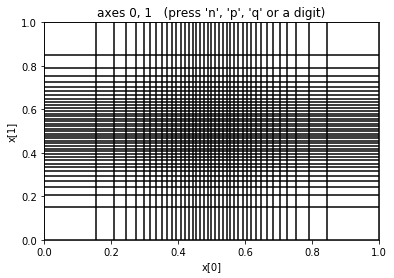

In [11]:
def create_funv(gn, gw):
    
    if(gn==1):
        def f(x):
                return np.exp(-np.sum((x-0.5)**2/(gw**2),-1))
        return f # peak at [0.5,...,0.5]
    
    if(gn==2):
        def f(x):
                return np.exp(-np.sum((x-0.25)**2/(gw**2),-1))+np.exp(-np.sum((x-0.75)**2/(gw**2),-1))
        return f  #peak at [0.25,...,0.25] and [0.75,...,0.75]
    
   
    if(gn==4):
        
        def f(x):
            shift=np.ones_like(x)*0.25
            shift1=shift.copy()*3
            lim=int((shift.shape[0]/2))
            shift2=np.concatenate((shift[:lim],shift1[lim:]),-1)
            shift3=np.concatenate((shift1[:lim],shift[lim:]),-1)
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))
        return f #peak at [0.25,...,0.25], [0.75,...,0.75],[0.25,...,0.75], [0.25,...,0.75]
                #in dim2, there would be in the [0,1] plane only two peaks, as two are identical
                # other than gn=2, the [1,2] plane has 4 peaks
              
    
    if(gn==8):
        
        def f(x):
            shift=np.ones_like(x)*0.25#000
            shift1=shift.copy()*3#111
            lim=int(shift.shape[0]/3)
            shift2=np.concatenate((shift[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #010
            shift3=np.concatenate((shift1[:lim],shift[lim:]),0)#100
            shift4=np.concatenate((shift1[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #110
            shift5=np.concatenate((shift[:2*lim],shift1[2*lim:]),0) #001
            shift6=np.concatenate((shift1[:lim],shift[lim:2*lim],shift1[2*lim:]),0) #101
            shift7=np.concatenate((shift[:lim],shift1[lim:]),0) #011
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))+ np.exp(-np.sum((x-shift4)**2/(gw**2),-1))+np.exp(-np.sum((x-shift5)**2/(gw**2),-1))+np.exp(-np.sum((x-shift6)**2/(gw**2),-1))+np.exp(-np.sum((x-shift7)**2/(gw**2),-1))
        return f #here, in [0,1] plane there are actually 4 peaks
    
ngrid=40
f=create_funv(1,0.25)

start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*2, ninc=ngrid)


ny = np.int(3000)
y = np.random.uniform(0., 1., (ny, 2))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)


for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()


m.show_grid(ngrid,[[0,1]])

In [12]:
for i in range(5):
    f=slashed_circle
    
    NF =  PWQuadManager(n_flow=2)
    
    #NF.create_model(n_cells=2, n_bins=9, NN=[11,11,11])
    NF.create_model(n_cells=2, NN=[16]*4, n_bins=8)
    optim = torch.optim.Adamax(NF._model.parameters(),lr= 0.00249, weight_decay=3.2E-04) 
    start_time=datetime.datetime.utcnow()
    sig, sig_err=NF._train_variance_forward_seq(f,optim,True, "./logs/tmp/",50000,500,0,True, True,None,0,mini_batch_size=10000, integrate=False,preburn_time=0,impr_ratio=1e-3, kill_counter=7,loss_mode="var")
    end_time=datetime.datetime.utcnow()
    print("---")
    print("Time")
    print((end_time-start_time).total_seconds())
    print('Best loss')
    print(NF.best_loss)
    print('Best loss relative')
    print(NF.best_loss_rel)
    print('Function evaluations')
    print(NF.best_func_count)

NameError: name 'slashed_circle' is not defined

the integral is 1.0002095128953834
249760 efficiency is 0.49952 max_f is 3.999999999720918e-06


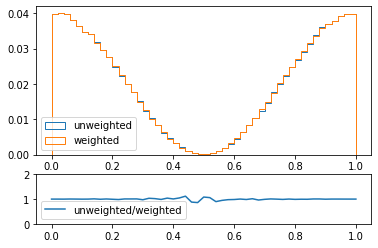

In [4]:
from __future__ import division
import math
import random

#parameter of the monte-carlo integraion
Ntry = 500000
fct = lambda x: 1 + math.cos(2*math.pi*x) # note that the function should be definite positive for this example

# initialise some global variable
all_try = []
max_f = 0
cross = 0

# perform the Monte-Carlo integration
for i in range(Ntry):
    x = random.random()
    f = fct(x)/Ntry
    all_try.append((x,f))
    max_f = max(max_f,f)
    cross += f

# perform the unweighting
accepted = []
for x,f in all_try:
    if random.random() < f/max_f:
        accepted.append(x)
    else:
        continue

print ("the integral is", cross)
print (len(accepted), 'efficiency is', len(accepted)/Ntry, "max_f is",max_f)

# plot the distribution from the unweighted events
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
n1, bins, patches = ax.hist(accepted, 50, weights=[max_f]*len(accepted), histtype='step', label='unweighted')
all_x = [x for x,f in all_try]
all_wgt = [f for x,f in all_try]
n2, bins, patches = ax.hist(all_x, 50, weights=all_wgt, histtype='step', label='weighted')
ratio = [n1[i]/n2[i] for i in range(len(n1))]
ax2.plot(bins, ratio+[1], label='unweighted/weighted')

ax.legend(loc=3)
ax2.set_ylim([0,2])
ax2.legend(loc=3)
plt.show()